## 1. Image Data Handling

In [1]:
%pylab inline

import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import keras as K
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, InputLayer, \
    Convolution2D, MaxPooling2D, Flatten,   \
    Dropout, BatchNormalization, GlobalAveragePooling2D

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# To stop potential randomness
seed = 42
rng = np.random.RandomState(seed)

In [3]:
data = pd.read_csv('../datasets/emergency_classification/emergency_classification.csv')

In [4]:
emergency_vehicles = glob('../datasets/emergency_classification/images/Emergency/*.jpg')
nonemergency_vehicles = glob('../datasets/emergency_classification/images/Non-Emergency/*.jpg')

In [5]:
len(emergency_vehicles), len(nonemergency_vehicles)

(991, 1361)

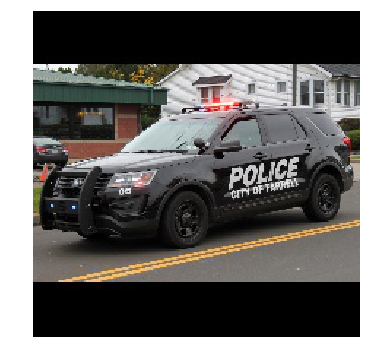

In [41]:
img_name = rng.choice(emergency_vehicles)

img = imread(img_name)

pylab.imshow(img)
pylab.axis('off')
pylab.show()

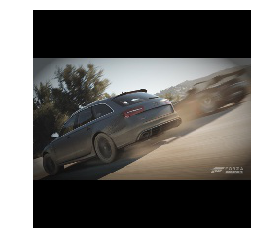

In [7]:
img_name = rng.choice(nonemergency_vehicles)

img = imread(img_name)

pylab.imshow(img)
pylab.axis('off')
pylab.show()

## 2. Data Loading and Preprocessing

In [4]:
images = []
for img_loc in data.image_names:
    img = image.load_img('../datasets/emergency_classification/images/' + img_loc)
    img = image.img_to_array(img)
    images.append(img)
    
images=np.array(images)

In [5]:
images.shape

(2352, 224, 224, 3)

In [6]:
train_x = images / images.max()
train_y = data.emergency_or_not.values

In [7]:
X_train, X_valid, Y_train, Y_valid=train_test_split(train_x,train_y,test_size=0.3, random_state=42)

## 3. Model Building

In [8]:
model = Sequential([
 InputLayer(input_shape=(224, 224, 3)),

 Convolution2D(32, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),

 Convolution2D(64, (5, 5), activation='relu', padding='same'),
 Convolution2D(64, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),

 Convolution2D(128, (5, 5), activation='relu', padding='same'),
 Convolution2D(128, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),
    
 Convolution2D(256, (5, 5), activation='relu', padding='same'),
 Convolution2D(256, (5, 5), activation='relu', padding='same'),
 MaxPooling2D(pool_size=2),
 BatchNormalization(),
    
 Convolution2D(512, (5, 5), activation='relu', padding='same'),
 Convolution2D(512, (5, 5), activation='relu', padding='same'),

 GlobalAveragePooling2D(),
 BatchNormalization(),

 Dense(units=512, activation='sigmoid'),
 BatchNormalization(),
 Dropout(0.5),
    
 Dense(units=1, activation='sigmoid'),
])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 64)        256       
__________

In [10]:
datagen = image.ImageDataGenerator(
    width_shift_range = 0.2,
    horizontal_flip = True
)

In [11]:
final_weights_path = '../models/best_cnn_model.h5'

callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_loss', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=20, verbose=1)
]

In [12]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [13]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),epochs=60,validation_data=(X_valid,Y_valid), callbacks=callbacks_list, shuffle=False, workers=5, use_multiprocessing=True)

Epoch 1/60
52/52 [==============================] - 15s 283ms/step - loss: 1.0375 - acc: 0.6017 - val_loss: 0.6691 - val_acc: 0.6289

Epoch 00001: val_loss improved from inf to 0.66912, saving model to ../models/best_cnn_model.h5
Epoch 2/60
52/52 [==============================] - 9s 173ms/step - loss: 0.6959 - acc: 0.6679 - val_loss: 0.7912 - val_acc: 0.5850

Epoch 00002: val_loss did not improve from 0.66912
Epoch 3/60
52/52 [==============================] - 9s 173ms/step - loss: 0.6462 - acc: 0.7050 - val_loss: 0.5494 - val_acc: 0.7394

Epoch 00003: val_loss improved from 0.66912 to 0.54937, saving model to ../models/best_cnn_model.h5
Epoch 4/60
52/52 [==============================] - 9s 174ms/step - loss: 0.5959 - acc: 0.7286 - val_loss: 1.2157 - val_acc: 0.5552

Epoch 00004: val_loss did not improve from 0.54937
Epoch 5/60
52/52 [==============================] - 9s 174ms/step - loss: 0.5415 - acc: 0.7570 - val_loss: 0.5970 - val_acc: 0.7337

Epoch 00005: val_loss did not improv

In [14]:
model.load_weights(final_weights_path)

In [15]:
predictions = model.predict_classes(X_valid).ravel()
prediction_probabilities = model.predict(X_valid).ravel()
all_vehicles = np.array(emergency_vehicles + nonemergency_vehicles)

_, valid_vehicles, _, valid_y = train_test_split(all_vehicles,train_y,test_size=0.3, random_state=42)

NameError: name 'emergency_vehicles' is not defined

In [ ]:
correct_predictions = valid_vehicles[predictions == Y_valid]

index = rng.choice(range(len(correct_predictions)))
img_name = correct_predictions[index]


prob = (prediction_probabilities[predictions == Y_valid] * 100).astype(int)[index]

img = imread(img_name)

print(prob , '% sure that it is emergency')
pylab.imshow(img)
pylab.axis('off')
pylab.show()

87 % sure that it is emergency


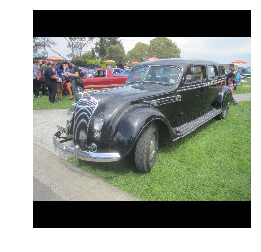

In [21]:
incorrect_predictions = valid_vehicles[predictions != Y_valid]
index = rng.choice(range(len(incorrect_predictions)))
img_name = incorrect_predictions[index]


prob = (prediction_probabilities[predictions != Y_valid] * 100).astype(int)[index]

img = imread(img_name)

print(prob , '% sure that it is emergency')
pylab.imshow(img)
pylab.axis('off')
pylab.show()

In [22]:
print(classification_report(predictions, Y_valid))

             precision    recall  f1-score   support

          0       0.92      0.91      0.91       400
          1       0.88      0.89      0.89       306

avg / total       0.90      0.90      0.90       706



In [23]:
tn, fp, fn, tp = confusion_matrix(predictions, Y_valid).ravel()

In [24]:
tn, tp, fn, fp

(363, 273, 33, 37)

In [25]:
roc_auc_score(predictions, Y_valid)

0.899828431372549

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


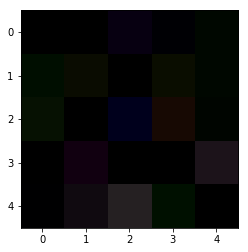

In [16]:
top_layer = model.layers[0]
plt.imshow(top_layer.get_weights()[0][:, :, :, 0].squeeze())
plt.show()

In [17]:
min_val = np.abs(top_layer.get_weights()[0][:, :, :, 0].squeeze().min())

In [18]:
min_val

0.099424995

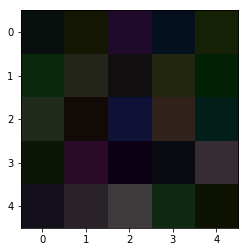

In [19]:
plt.imshow(top_layer.get_weights()[0][:, :, :, 0].squeeze() + min_val)

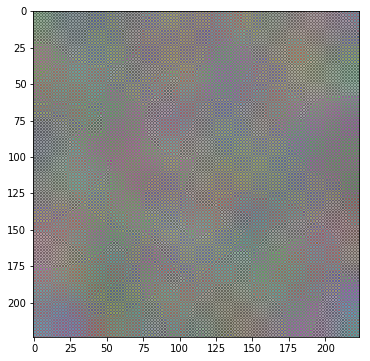

In [20]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

plt.rcParams['figure.figsize'] = (18, 6)

layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img)

In [21]:
img.shape

(224, 224, 3)

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed t

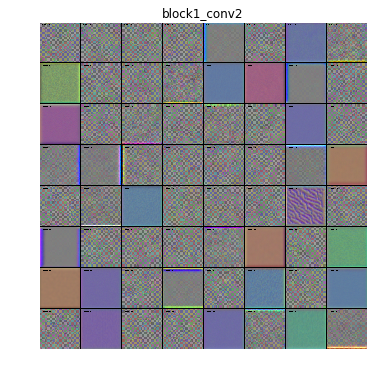

In [39]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_idx = 4

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))

# Generate input image for each filter.
vis_images = []
for idx in filters[:4]:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [52]:
img_name = rng.choice(emergency_vehicles)

img = imread(img_name)

<Figure size 1296x432 with 0 Axes>

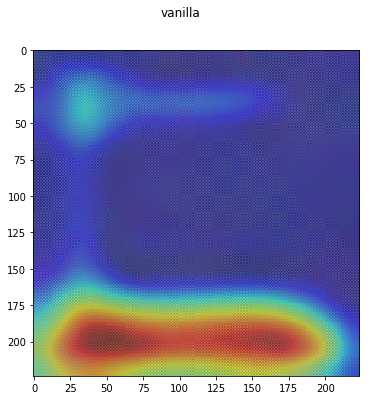

In [22]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay


plt.figure()
f, ax = plt.subplots()
plt.suptitle("vanilla")

grads = visualize_cam(model, -1, filter_indices=0, 
                      seed_input=img, backprop_modifier=None)        
# Lets overlay the heatmap onto original image.    
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
ax.imshow(overlay(jet_heatmap, img))

<Figure size 1296x432 with 0 Axes>

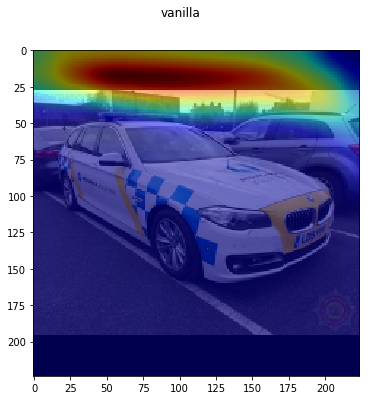

<Figure size 1296x432 with 0 Axes>

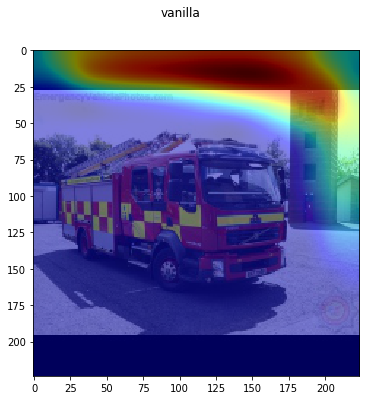

<Figure size 1296x432 with 0 Axes>

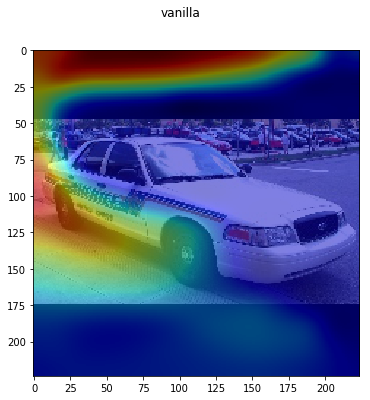

<Figure size 1296x432 with 0 Axes>

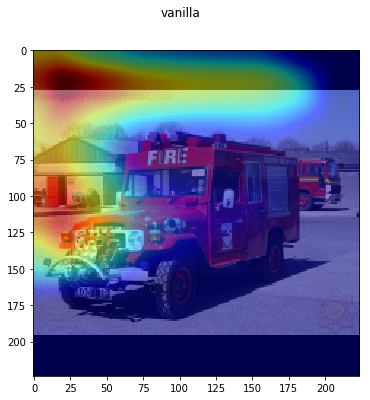

<Figure size 1296x432 with 0 Axes>

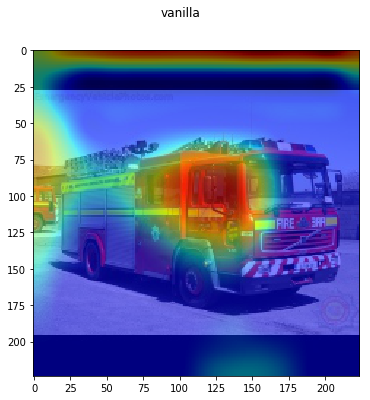

<Figure size 1296x432 with 0 Axes>

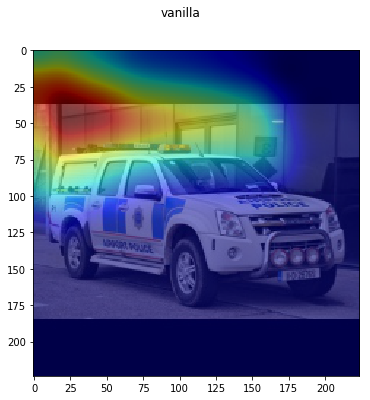

<Figure size 1296x432 with 0 Axes>

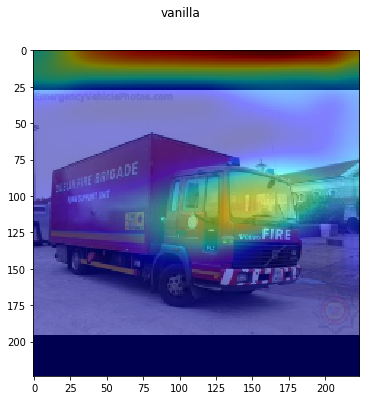

<Figure size 1296x432 with 0 Axes>

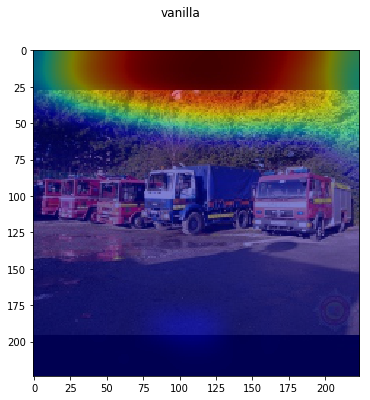

<Figure size 1296x432 with 0 Axes>

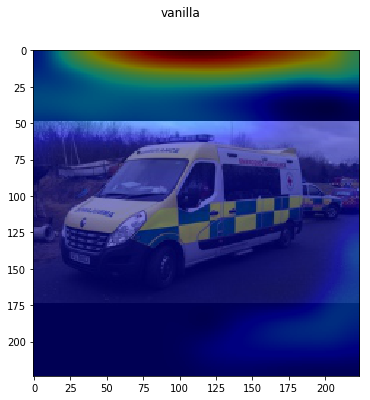

<Figure size 1296x432 with 0 Axes>

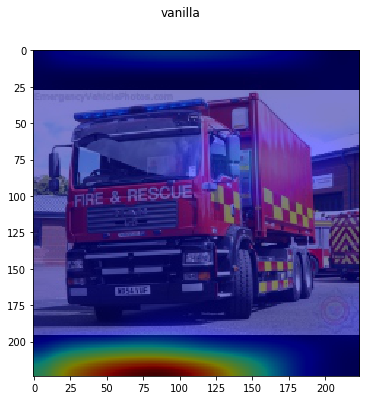

<Figure size 1296x432 with 0 Axes>

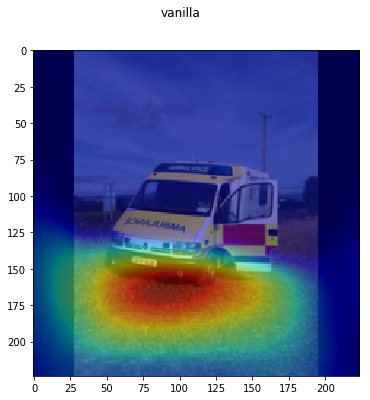

<Figure size 1296x432 with 0 Axes>

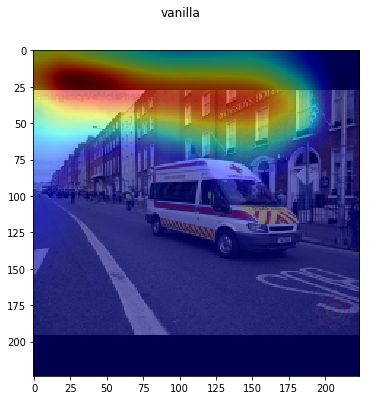

<Figure size 1296x432 with 0 Axes>

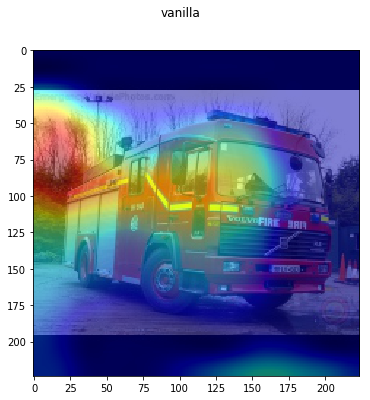

<Figure size 1296x432 with 0 Axes>

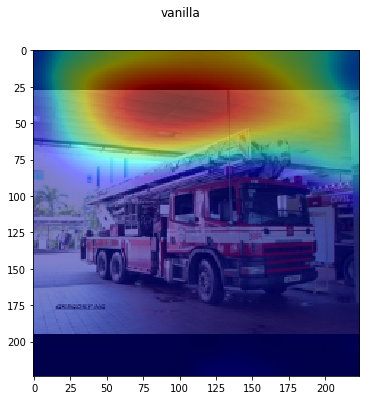

<Figure size 1296x432 with 0 Axes>

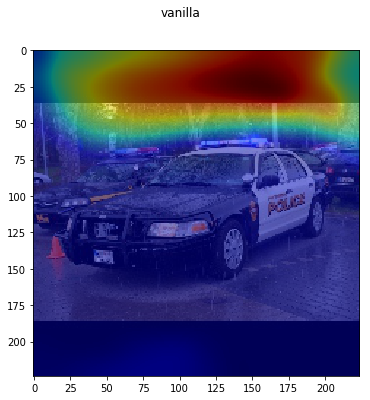

<Figure size 1296x432 with 0 Axes>

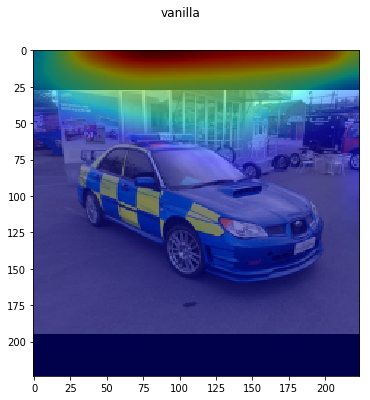

<Figure size 1296x432 with 0 Axes>

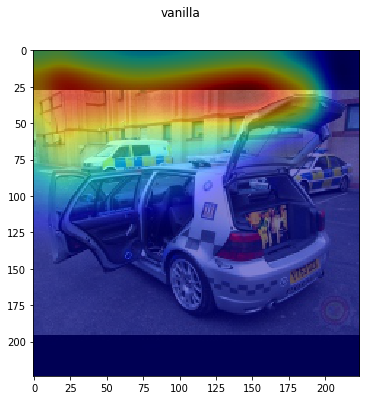

<Figure size 1296x432 with 0 Axes>

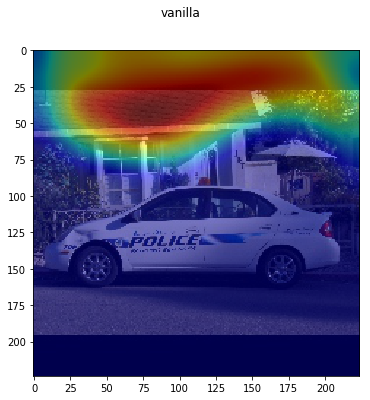

<Figure size 1296x432 with 0 Axes>

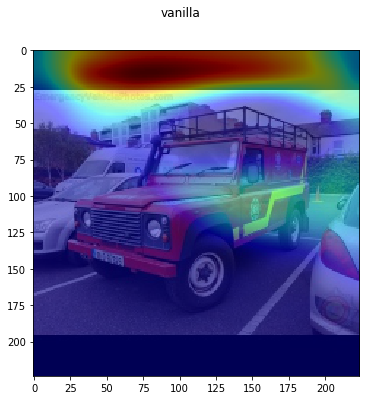

<Figure size 1296x432 with 0 Axes>

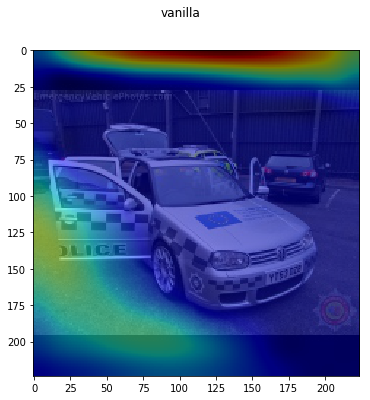

<Figure size 1296x432 with 0 Axes>

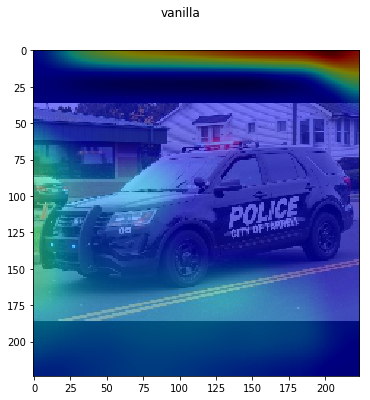

<Figure size 1296x432 with 0 Axes>

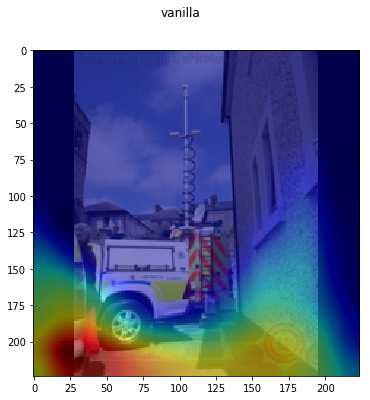

<Figure size 1296x432 with 0 Axes>

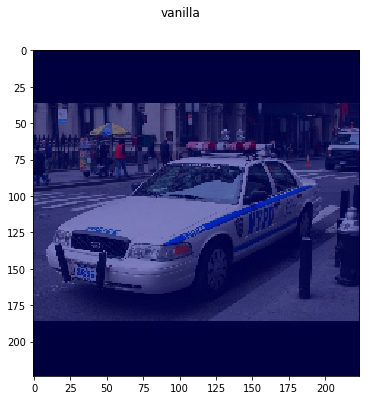

<Figure size 1296x432 with 0 Axes>

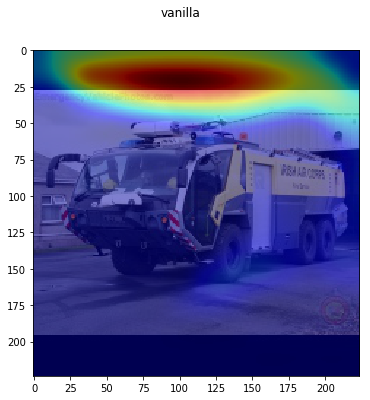

<Figure size 1296x432 with 0 Axes>

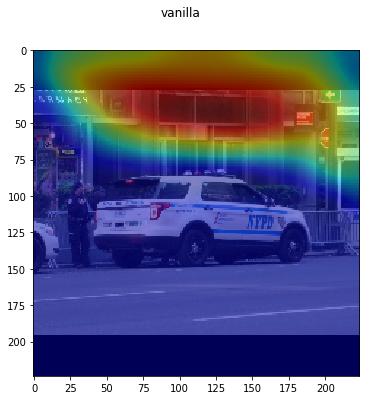

<Figure size 1296x432 with 0 Axes>

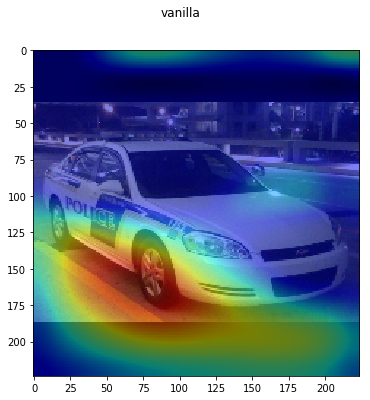

<Figure size 1296x432 with 0 Axes>

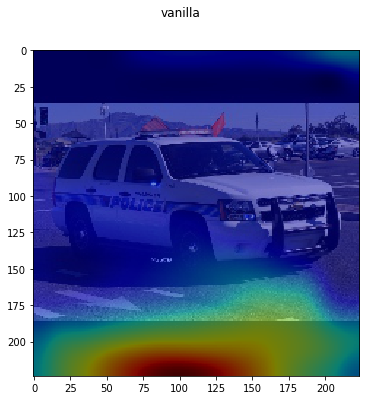

<Figure size 1296x432 with 0 Axes>

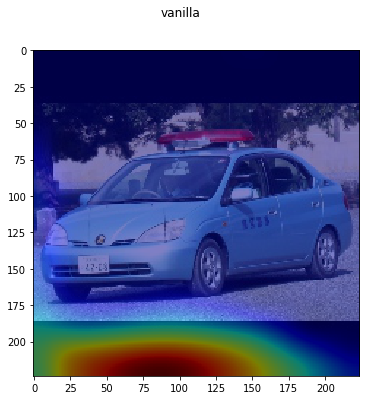

<Figure size 1296x432 with 0 Axes>

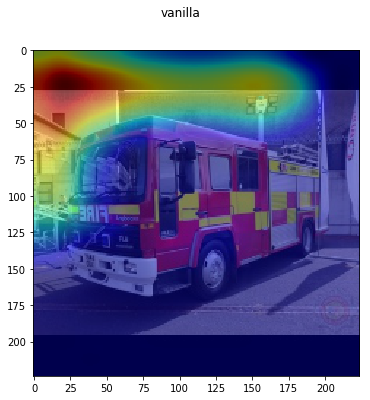

<Figure size 1296x432 with 0 Axes>

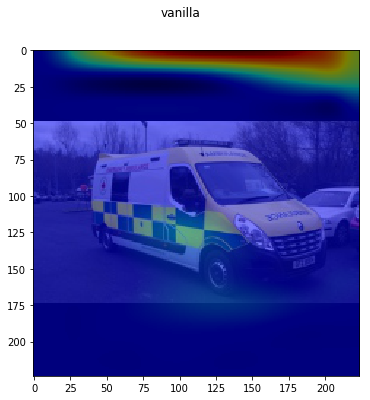

<Figure size 1296x432 with 0 Axes>

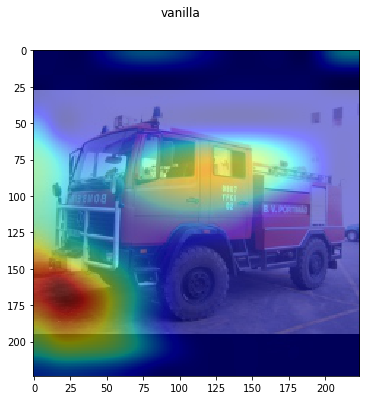

<Figure size 1296x432 with 0 Axes>

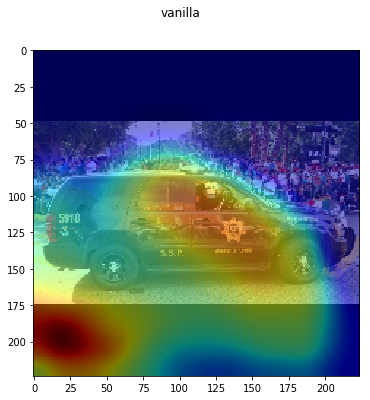

<Figure size 1296x432 with 0 Axes>

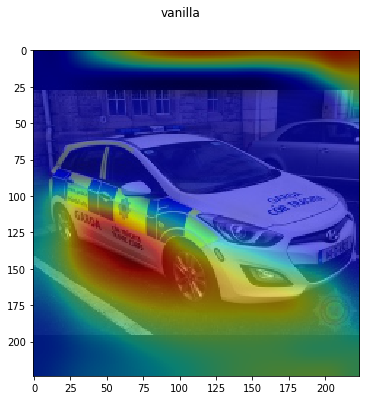

<Figure size 1296x432 with 0 Axes>

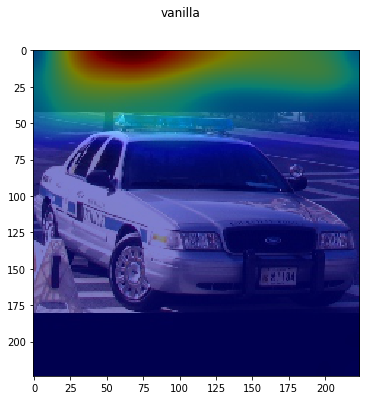

<Figure size 1296x432 with 0 Axes>

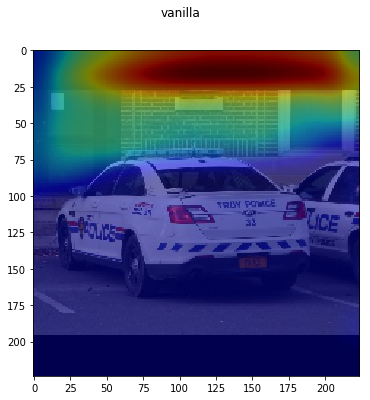

<Figure size 1296x432 with 0 Axes>

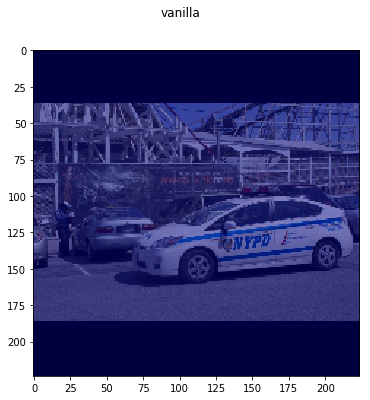

<Figure size 1296x432 with 0 Axes>

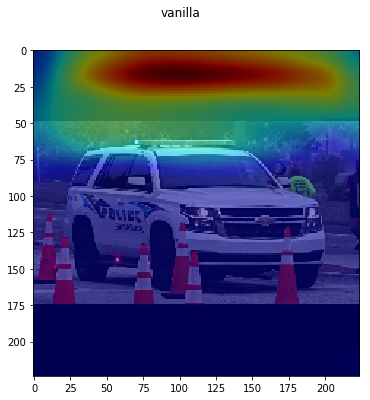

<Figure size 1296x432 with 0 Axes>

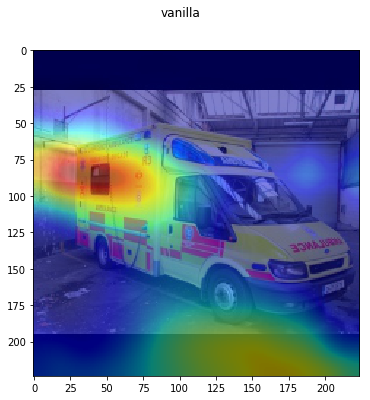

<Figure size 1296x432 with 0 Axes>

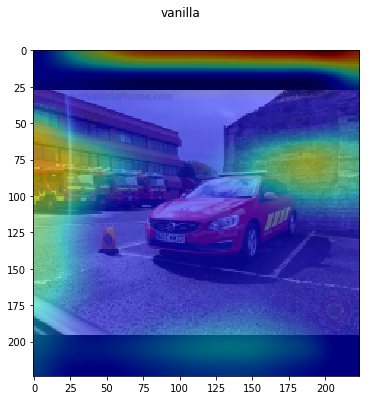

KeyboardInterrupt: 

<Figure size 1296x432 with 0 Axes>

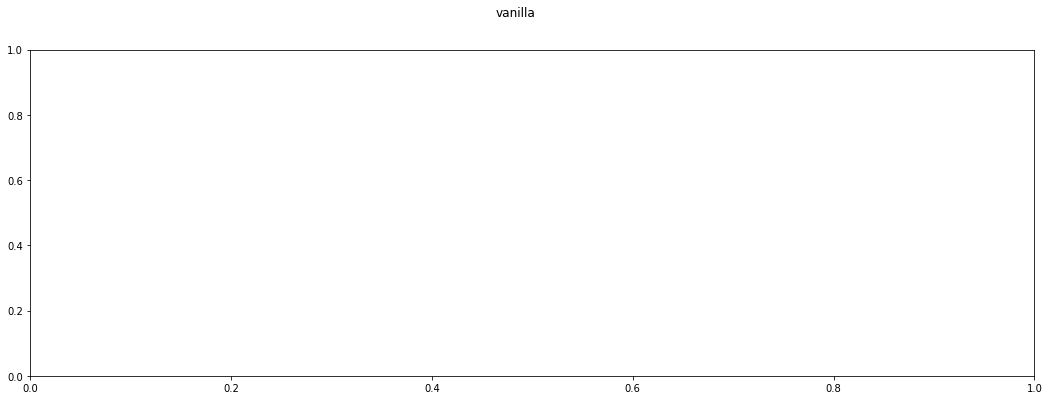

In [55]:
for img_name in emergency_vehicles:
    img = imread(img_name)
    
    plt.figureemergency_vehicles    f, ax = plt.subplots()
    plt.suptitle("vanilla")

    grads = visualize_cam(model, -1, filter_indices=0, 
                          seed_input=img, backprop_modifier=None)        
    # Lets overlay the heatmap onto original image.    
    jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
    ax.imshow(overlay(jet_heatmap, img))
    plt.show()

In [24]:
vehicles = glob('../datasets/emergency_classification/images/*.jpg')

<Figure size 1296x432 with 0 Axes>

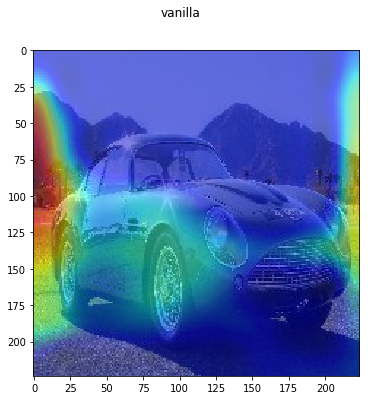

In [42]:
img_name = vehicles[285]
img = imread(img_name)

plt.figure()
f, ax = plt.subplots()
plt.suptitle("vanilla")

grads = visualize_cam(model, -1, filter_indices=0, 
                      seed_input=img, backprop_modifier=None)        
# Lets overlay the heatmap onto original image.    
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
ax.imshow(overlay(jet_heatmap, img))
plt.show()